![](https://media-fastly.hackerearth.com/media/hackathon/hackerearth-machine-learning-challenge-pet-adoption/images/b96edbc6d2-PetAdoption_FBImage.jpg)

[**HackerEarth: Machine Learning Challenge - Adopt a buddy**](https://www.hackerearth.com/challenges/competitive/hackerearth-machine-learning-challenge-pet-adoption/)

**Problem Statement**

A leading pet adoption agency is planning to create a virtual tour experience for their customers showcasing all animals that are available in 
their shelter. To enable this tour experience, you are required to build a Machine Learning model that determines type and breed of the 
animal based on its physical attributes and other factors.

Data Description:

The data folder consists of 2 CSV files
   • **train.csv** - 18834 x 11
   • **test.csv** - 8072 x 9


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hackerearth-ml-challenge-adopt-a-buddy/train.csv
/kaggle/input/hackerearth-ml-challenge-adopt-a-buddy/test.csv


In [2]:
# Import useful libraries

import time
import re
import string
from numpy import mean
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest, f_classif

import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, KFold, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.multiclass import type_of_target

from catboost import CatBoostClassifier
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Read dataset

train_data = pd.read_csv('/kaggle/input/hackerearth-ml-challenge-adopt-a-buddy/train.csv')
test_data = pd.read_csv('/kaggle/input/hackerearth-ml-challenge-adopt-a-buddy/test.csv')
train_data.columns = train_data.columns.str.lower().str.strip().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
test_data.columns = test_data.columns.str.lower().str.strip().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

In [4]:
print('Train Data Shape: ', train_data.shape)
print('Test Data Shape: ', test_data.shape)
train_data.head()

Train Data Shape:  (18834, 11)
Test Data Shape:  (8072, 9)


,pet_id,issue_date,listing_date,condition,color_type,lengthm,heightcm,x1,x2,breed_category,pet_category
0,ANSL_69903,2016-07-10 00:00:00,2016-09-21 16:25:00,2.0,Brown Tabby,0.80,7.78,13,9,0.0,1
1,ANSL_66892,2013-11-21 00:00:00,2018-12-27 17:47:00,1.0,White,0.72,14.19,13,9,0.0,2
2,ANSL_69750,2014-09-28 00:00:00,2016-10-19 08:24:00,NaN,Brown,0.15,40.90,15,4,2.0,4
3,ANSL_71623,2016-12-31 00:00:00,2019-01-25 18:30:00,1.0,White,0.62,17.82,0,1,0.0,2
4,ANSL_57969,2017-09-28 00:00:00,2017-11-19 09:38:00,2.0,Black,0.50,11.06,18,4,0.0,1


In [5]:
train_data.isnull().sum()

pet_id               0
issue_date           0
listing_date         0
condition         1477
color_type           0
lengthm              0
heightcm             0
x1                   0
x2                   0
breed_category       0
pet_category         0
dtype: int64

# Exploratory Data Analysis

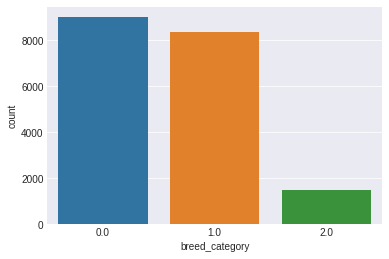

In [6]:
# See the distribution of outcome 1: breed_category

sns.countplot(x = 'breed_category',data = train_data)
sns.despine()

**It appears that breed category 2 is a minority class. We can use Smote from imblearn to oversample this class**

In [7]:
print(train_data.breed_category.value_counts())
print(train_data.pet_category.value_counts())

0.0    9000
1.0    8357
2.0    1477
Name: breed_category, dtype: int64
2    10621
1     7184
4      941
0       88
Name: pet_category, dtype: int64


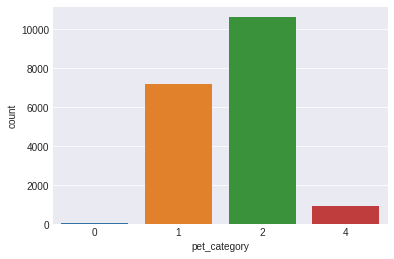

In [8]:
# See the distribution of outcome 2: pet_category

sns.countplot(x = 'pet_category',data = train_data)
sns.despine()

**It appears that pet category 0 and 4 are among minority classes. We can use Smote from imblearn to oversample these classes**

### Analysing other features in combined train and test data

In [9]:
train_data['type'] = 'train'
test_data['type'] = 'test'

master_data = pd.concat([train_data, test_data])
master_data['issue_date'] = pd.to_datetime(master_data['issue_date'], dayfirst = True)
master_data['listing_date'] = pd.to_datetime(master_data['listing_date'].apply(lambda x: x.split(' ')[0]), dayfirst = True)

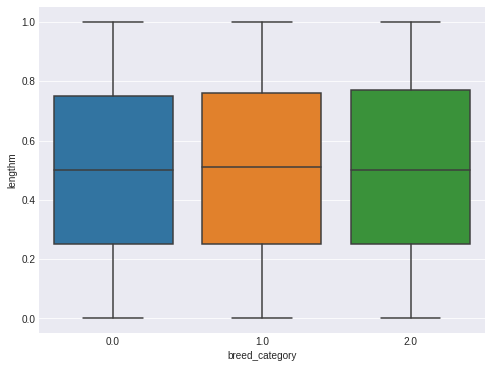

In [10]:
# Relation between length and breed category

plt.figure(figsize = (8, 6))
sns.boxplot(x = 'breed_category',y = 'lengthm',data = master_data)
plt.show()

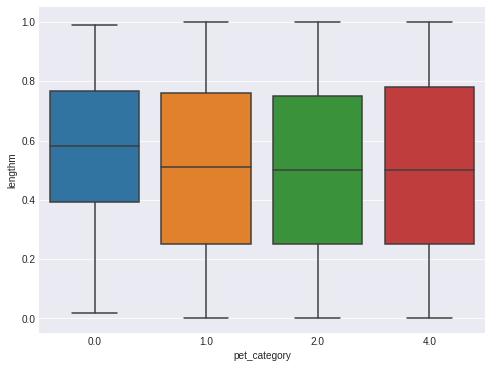

In [11]:
# Relation between length and pet category

plt.figure(figsize = (8, 6))
sns.boxplot(x = 'pet_category',y = 'lengthm',data = master_data)
plt.show()

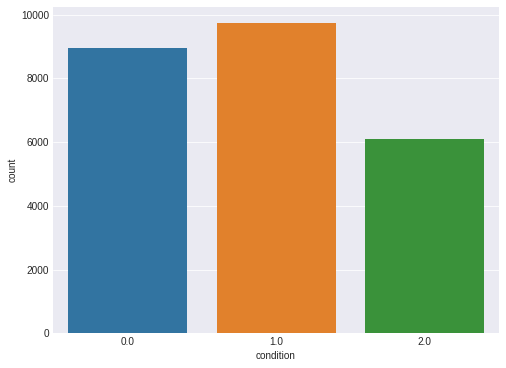

In [12]:
# See the distribution of outcome 2: pet_category

plt.figure(figsize = (8, 6))
sns.countplot(x = 'condition',data = master_data)
sns.despine()

We can treat the missing class - nan as a separate category itself

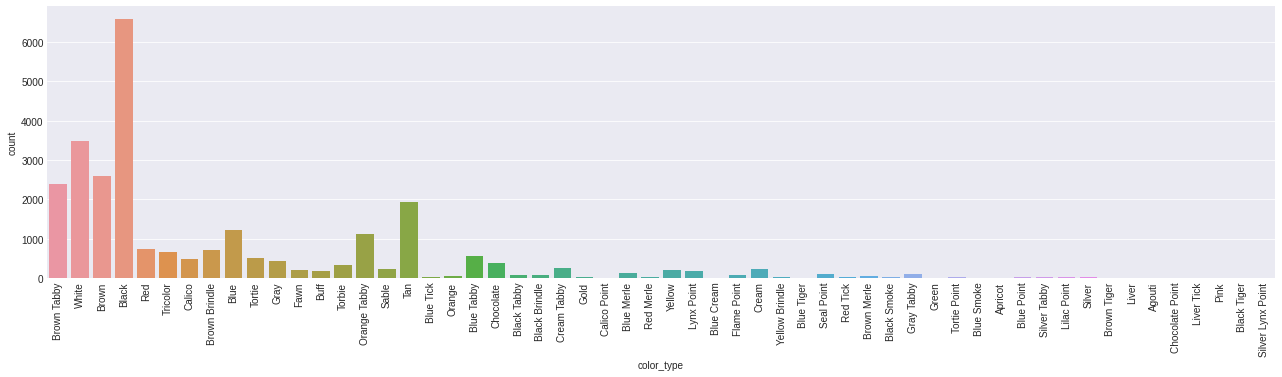

In [13]:
# See the distribution of outcome 1: breed_category

plt.figure(figsize = (22, 5))
sns.countplot(x = 'color_type',data = master_data)
plt.xticks(rotation = 90)
plt.show()

**More than half of the features are among miority classes, we can extract first word to create new color feature to reduce the classes here**

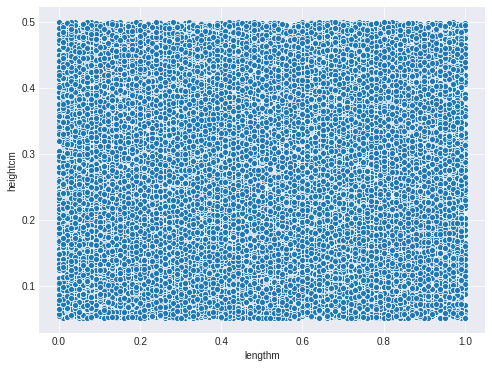

In [14]:
plt.figure(figsize = (8, 6))
sns.scatterplot(x = master_data['lengthm'], y = master_data['heightcm']/100)
plt.show()

1. **Both the features length and height can be dropped which led to improvement of score by 1**
2. **Note: If using dimension features - convert to same unit (m/cm)**

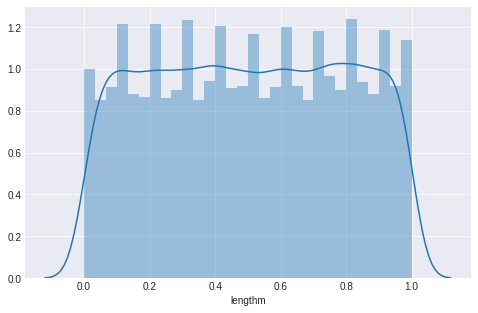

In [15]:
plt.figure(figsize = (8, 5))
sns.distplot(master_data['lengthm'])
plt.show()

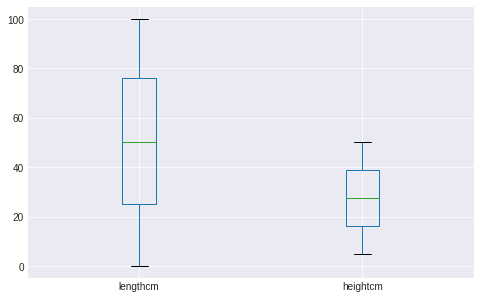

In [16]:
plt.figure(figsize = (8, 5))
df = master_data[['lengthm','heightcm']]
df['lengthcm'] = df['lengthm']*100
df[['lengthcm','heightcm']].boxplot()
plt.show()

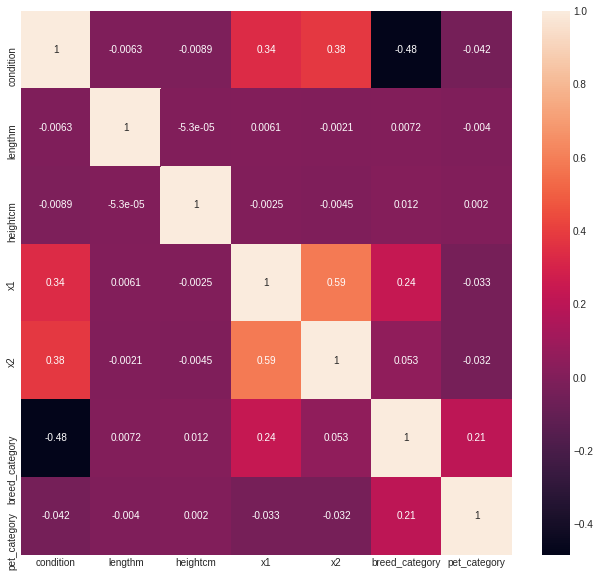

In [17]:
# Correlation matrix

plt.figure(figsize = (11, 10))
#plt.subplots(figsize=(10,8))
sns.heatmap(master_data.corr(), annot = True)

## Insights

* **Drop the pet dimension columns and x2 if required as they are weakly correlated and don't have enough predicting power for the 2 target variables**

### Feature Engineering - New features

In [18]:
master_data['days_to_reach'] = master_data['listing_date'] - master_data['issue_date']
master_data['days_to_reach'] = master_data['days_to_reach'].apply(lambda x: int(str(x).split(' ')[0]))

master_data['age'] = master_data['days_to_reach'] / 365
master_data['age'] = master_data['age'].abs()

# Mapping for condition of pets

condition = {0.0: 'A', 1.0: 'B', 2.0: 'C'}
master_data['condition'] = master_data['condition'].map(condition)
master_data['condition'] = master_data['condition'].astype(str)

# Convert height to cms

master_data['heightm'] = master_data['heightcm'] / 100
master_data = master_data.drop(['heightcm'], axis = 1)

#length_mean = master_data['lengthm'].mean()

master_data.loc[(master_data['lengthm'] == 0), 'lengthm'] = 0.005

#master_data['len_to_height'] = master_data['lengthm']/master_data['heightm']

master_data['color_type'] = master_data['color_type'].apply(lambda x: x.lower())



master_data.head()

,pet_id,issue_date,listing_date,condition,color_type,lengthm,x1,x2,breed_category,pet_category,type,days_to_reach,age,heightm
0,ANSL_69903,2016-07-10,2016-09-21,C,brown tabby,0.80,13,9,0.0,1.0,train,73,0.200000,0.0778
1,ANSL_66892,2013-11-21,2018-12-27,B,white,0.72,13,9,0.0,2.0,train,1862,5.101370,0.1419
2,ANSL_69750,2014-09-28,2016-10-19,nan,brown,0.15,15,4,2.0,4.0,train,752,2.060274,0.4090
3,ANSL_71623,2016-12-31,2019-01-25,B,white,0.62,0,1,0.0,2.0,train,755,2.068493,0.1782
4,ANSL_57969,2017-09-28,2017-11-19,C,black,0.50,18,4,0.0,1.0,train,52,0.142466,0.1106


In [19]:
# 2 records exist where the listing date is less than the issue date, convert them to positive

master_data.loc[(master_data['days_to_reach'] <= 0), 'days_to_reach'] = master_data.loc[(master_data['days_to_reach'] < 0), 'days_to_reach'] * -1

In [20]:
# Generate master color feature from the available color_type

master_data['master_color'] = master_data['color_type'].apply(lambda x: x.split(' ')[0])
master_data['species'] = master_data['color_type'].apply(lambda x: x.split(' ')[1] if len(x.split(' ')) == 2 else x.split(' ')[0])

In [21]:
# Generate time features - e.g. Quarter

master_data['issue_qtr'] = master_data['issue_date'].dt.quarter
master_data['list_qtr'] = master_data['listing_date'].dt.quarter

master_data['issue_yr'] = master_data['issue_date'].dt.year
master_data['list_yr'] = master_data['listing_date'].dt.year

master_data['issue_mth'] = master_data['issue_date'].dt.month
master_data['list_mth'] = master_data['listing_date'].dt.month

master_data['issue_weekend'] = master_data['issue_date'].apply(lambda x: 1 if x.dayofweek in [5, 6] else 0)
master_data['list_weekend'] = master_data['listing_date'].apply(lambda x: 1 if x.dayofweek in [5, 6] else 0)

master_data.head()

,pet_id,issue_date,listing_date,condition,color_type,lengthm,x1,x2,breed_category,pet_category,...,master_color,species,issue_qtr,list_qtr,issue_yr,list_yr,issue_mth,list_mth,issue_weekend,list_weekend
0,ANSL_69903,2016-07-10,2016-09-21,C,brown tabby,0.80,13,9,0.0,1.0,...,brown,tabby,3,3,2016,2016,7,9,1,0
1,ANSL_66892,2013-11-21,2018-12-27,B,white,0.72,13,9,0.0,2.0,...,white,white,4,4,2013,2018,11,12,0,0
2,ANSL_69750,2014-09-28,2016-10-19,nan,brown,0.15,15,4,2.0,4.0,...,brown,brown,3,4,2014,2016,9,10,1,0
3,ANSL_71623,2016-12-31,2019-01-25,B,white,0.62,0,1,0.0,2.0,...,white,white,4,1,2016,2019,12,1,1,0
4,ANSL_57969,2017-09-28,2017-11-19,C,black,0.50,18,4,0.0,1.0,...,black,black,3,4,2017,2017,9,11,0,1


In [22]:
# Get numerical columns

cat_cols = ['condition', 'color_type', 'master_color', 'species']
numerical_cols = master_data.columns[~master_data.columns.isin(cat_cols + ['pet_id', 'issue_date', 'listing_date', 'type', 'breed_category', 'pet_category'])].tolist()
numerical_cols

['lengthm',
 'x1',
 'x2',
 'days_to_reach',
 'age',
 'heightm',
 'issue_qtr',
 'list_qtr',
 'issue_yr',
 'list_yr',
 'issue_mth',
 'list_mth',
 'issue_weekend',
 'list_weekend']

## Standard Scaling the data

In [23]:
ss = StandardScaler()
master_data[numerical_cols] = ss.fit_transform(master_data[numerical_cols])

## Label Encoding only done to find out kBest parameters using ANOVA score

* **Uncomment and run below cell only to find out kBest columns & then run entire script without label encoding the feature columns**

In [24]:
#le = LabelEncoder()
#for col in cat_cols:
#    master_data[col] = le.fit_transform(master_data[col])
    
#master_data[numerical_cols + cat_cols] = ss.fit_transform(master_data[numerical_cols + cat_cols])

In [25]:
train_data.columns

Index(['pet_id', 'issue_date', 'listing_date', 'condition', 'color_type',
       'lengthm', 'heightcm', 'x1', 'x2', 'breed_category', 'pet_category',
       'type'],
      dtype='object')

### Separating the data back to train and test

In [26]:
# Separate train and test data

train_data = master_data.loc[master_data['type'] == 'train']
test_data = master_data.loc[master_data['type'] == 'test']

train_data['breed_category'] =train_data['breed_category'].astype(str)
train_data['pet_category'] =train_data['pet_category'].astype(str)

testIDs = test_data['pet_id']

train_data = train_data.drop(['pet_id', 'issue_date', 'listing_date', 'type'], axis = 1)

for col in ['breed_category', 'pet_category']:
    train_data[col] = train_data[col].apply(lambda x: np.float16(x))
    train_data[col] = train_data[col].apply(lambda x: np.int8(x))

testData = test_data.drop(['issue_date', 'listing_date', 'type', 'x2', 'breed_category', 'pet_category'], axis = 1)
test_data = test_data.drop(['pet_id', 'issue_date', 'listing_date', 'type', 'x2', 'breed_category', 'pet_category'], axis = 1)
train_data = train_data[['condition', 'color_type', 'lengthm', 'x1', 'days_to_reach', 'age', 'heightm', 'master_color', 'species', 'issue_qtr', 'list_qtr',
                         'breed_category', 'issue_yr', 'list_yr', 'issue_mth', 'list_mth', 'issue_weekend', 'list_weekend', 'pet_category']]
train_data.head()

,condition,color_type,lengthm,x1,days_to_reach,age,heightm,master_color,species,issue_qtr,list_qtr,breed_category,issue_yr,list_yr,issue_mth,list_mth,issue_weekend,list_weekend,pet_category
0,C,brown tabby,1.024293,1.169789,-0.712215,-0.712215,-1.514343,brown,tabby,0.364997,0.349040,0,0.295461,-1.509344,0.062139,0.622139,1.554832,-0.644889,1
1,B,white,0.747411,1.169789,0.916016,0.916016,-1.020842,white,white,1.294275,1.215154,0,-0.670477,0.605726,1.277405,1.457140,-0.643156,-0.644889,2
2,nan,brown,-1.225378,1.475018,-0.094233,-0.094233,1.035542,brown,brown,0.364997,1.215154,2,-0.348498,-1.509344,0.669772,0.900472,1.554832,-0.644889,4
3,B,white,0.401307,-0.814202,-0.091503,-0.091503,-0.741371,white,white,1.294275,-1.383188,0,0.295461,1.663261,1.581222,-1.604531,1.554832,-0.644889,2
4,C,black,-0.014017,1.932862,-0.731328,-0.731328,-1.261818,black,black,0.364997,1.215154,0,0.617440,-0.451809,0.669772,1.178806,-0.643156,1.550655,1


In [27]:
test_data.head()

,condition,color_type,lengthm,x1,days_to_reach,age,heightm,master_color,species,issue_qtr,list_qtr,issue_yr,list_yr,issue_mth,list_mth,issue_weekend,list_weekend
0,A,black,1.266565,-0.814202,3.229578,3.229578,1.176432,black,black,0.364997,0.349040,-3.246311,-0.451809,0.365955,0.622139,-0.643156,-0.644889
1,B,orange tabby,-1.536871,-0.814202,-0.620291,-0.620291,-1.596722,orange,tabby,1.294275,-0.517074,0.939419,1.663261,1.277405,-0.491196,-0.643156,-0.644889
2,B,black,-0.913885,-0.814202,1.040704,1.040704,1.059409,black,black,1.294275,-0.517074,-0.992456,0.605726,0.973589,-0.769530,-0.643156,-0.644889
3,B,black,-0.740833,0.254101,0.266180,0.266180,-1.461991,black,black,-1.493559,-0.517074,-0.026518,0.605726,-1.456945,-0.769530,-0.643156,-0.644889
4,B,brown,0.712800,-0.814202,-0.357262,-0.357262,0.267189,brown,brown,-1.493559,-0.517074,0.617440,0.605726,-1.760761,-0.769530,-0.643156,-0.644889


## Selecting KBest features using Anova F test

* Uncomment below 2 cells only for kBest features

## Part 1: Pet Category

In [28]:
train_data_1 = train_data.copy()
"""
X1 = train_data_1.drop(['breed_category', 'pet_category'],axis = 1).values
y1 = train_data_1['pet_category'].values

for num_feats in range(1, 9):
    print('Using {} features:'.format(num_feats))
    test = SelectKBest(score_func = f_classif, k = num_feats)
    fit = test.fit(X1, y1)
    # summarize scores
    set_printoptions(precision = 0)
    for i in fit.scores_:
        print(i)
    print(fit.scores_)
    features = fit.transform(X1)
    # summarize selected features
    print(features[0:num_feats + 1, :])
"""

"\nX1 = train_data_1.drop(['breed_category', 'pet_category'],axis = 1).values\ny1 = train_data_1['pet_category'].values\n\nfor num_feats in range(1, 9):\n    print('Using {} features:'.format(num_feats))\n    test = SelectKBest(score_func = f_classif, k = num_feats)\n    fit = test.fit(X1, y1)\n    # summarize scores\n    set_printoptions(precision = 0)\n    for i in fit.scores_:\n        print(i)\n    print(fit.scores_)\n    features = fit.transform(X1)\n    # summarize selected features\n    print(features[0:num_feats + 1, :])\n"

#### It appears we can drop length and height features as they carry lowest Anova F score

## Part 2: Breed Category

In [29]:
"""
X2 = train_data_1.drop(['breed_category'],axis = 1).values
y2 = train_data_1['breed_category'].values

for num_feats in range(1, 10):
    print('Using {} features:'.format(num_feats))
    test = SelectKBest(score_func = f_classif, k = num_feats)
    fit = test.fit(X2, y2)
    # summarize scores
    set_printoptions(precision = 0)
    for i in fit.scores_:
        print(i)
    print(fit.scores_)
    features = fit.transform(X2)
    # summarize selected features
    print(features[0:num_feats + 1, :])
"""

"\nX2 = train_data_1.drop(['breed_category'],axis = 1).values\ny2 = train_data_1['breed_category'].values\n\nfor num_feats in range(1, 10):\n    print('Using {} features:'.format(num_feats))\n    test = SelectKBest(score_func = f_classif, k = num_feats)\n    fit = test.fit(X2, y2)\n    # summarize scores\n    set_printoptions(precision = 0)\n    for i in fit.scores_:\n        print(i)\n    print(fit.scores_)\n    features = fit.transform(X2)\n    # summarize selected features\n    print(features[0:num_feats + 1, :])\n"

In [30]:
train_data_1 = train_data.drop(['lengthm', 'heightm'], axis = 1)

test_data_1 = test_data.copy()
test_data_1 = test_data.drop(['lengthm', 'heightm'], axis = 1)

In [31]:
X = train_data_1.drop(['breed_category', 'pet_category'],axis = 1).values
y_1 = train_data_1['pet_category'].values

_cat_indices_ = [0, 1, 5, 6]
#_cat_indices_ = [0, 4, 5]


type_of_target(y_1)

'multiclass'

# Model Building

## CatBoost Model

### Part 1: Predict the pet_category target class

Predict the target variable **pet_category** which is independent of the **breed_category** class

--> Model: CatBoost
--> KFold splits: 6

In [32]:
# Catboost for pet_category

kfold, scores = KFold(n_splits = 6, shuffle = True, random_state = 22), list()
for train, test in kfold.split(X):
    X_train, X_test = X[train], X[test]
    y_train, y_test = y_1[train], y_1[test]

    model = CatBoostClassifier(random_state = 22, max_depth = 6, n_estimators = 1000, verbose = 1000, l2_leaf_reg = 1)
    model.fit(X_train, y_train, cat_features = _cat_indices_)
    preds = model.predict(X_test)
    score = f1_score(y_test, preds, average = 'weighted')
    scores.append(score)
    print('Validation f1_score:', score)
print("Average Validation f1_score: ", sum(scores)/len(scores))

0:	learn: 1.3181943	total: 117ms	remaining: 1m 57s
999:	learn: 0.1928949	total: 51.7s	remaining: 0us
Validation f1_score: 0.9038766618040424
0:	learn: 1.3180951	total: 57.1ms	remaining: 57.1s
999:	learn: 0.1953748	total: 52.8s	remaining: 0us
Validation f1_score: 0.906242053582155
0:	learn: 1.3179749	total: 53.5ms	remaining: 53.5s
999:	learn: 0.1918930	total: 52s	remaining: 0us
Validation f1_score: 0.9069811110342803
0:	learn: 1.3181642	total: 54.6ms	remaining: 54.6s
999:	learn: 0.1924507	total: 52.8s	remaining: 0us
Validation f1_score: 0.901905249889567
0:	learn: 1.3185230	total: 117ms	remaining: 1m 56s
999:	learn: 0.1928832	total: 1m 3s	remaining: 0us
Validation f1_score: 0.9075685462605112
0:	learn: 1.3216226	total: 51.4ms	remaining: 51.4s
999:	learn: 0.1931346	total: 52.1s	remaining: 0us
Validation f1_score: 0.9085990159853927
Average Validation f1_score:  0.9058621064259915


In [33]:
y_Preds_1 = model.predict(test_data_1.values)

In [34]:
pet_cat = pd.DataFrame(data = {'pet_id': testIDs, 'pet_category': y_Preds_1.ravel()})
pet_cat.head()

,pet_id,pet_category
0,ANSL_75005,2
1,ANSL_76663,1
2,ANSL_58259,2
3,ANSL_67171,2
4,ANSL_72871,2


In [35]:
test_data_1 = testData.merge(pet_cat, on = 'pet_id', how = 'left')
test_data_1 = test_data_1.drop(['pet_id', 'heightm', 'lengthm'], axis = 1)

### Part 2: Predict the breed_category target class

Predict the target variable **breed_category** which is dependent of the **pet_category** class

--> Model: CatBoost
--> KFold splits: 6

In [36]:
X = train_data_1.drop(['breed_category', 'issue_yr', 'list_yr', 'issue_mth', 'list_mth', 'issue_weekend', 'list_weekend'],axis = 1).values
y_2 = train_data_1['breed_category'].values

_cat_indices_ = [0, 1, 5, 6, 9]
#_cat_indices_ = [0, 4, 5, 8]

type_of_target(y_2)

'multiclass'

In [37]:
# Catboost for breed_category

kfold, scores = KFold(n_splits = 6, shuffle = True, random_state = 22), list()
for train, test in kfold.split(X):
    X_train, X_test = X[train], X[test]
    y_train, y_test = y_2[train], y_2[test]

    model_1 = CatBoostClassifier(random_state = 22, max_depth = 8, n_estimators = 1000, verbose = 1000)
    model_1.fit(X_train, y_train, cat_features = _cat_indices_)
    preds = model_1.predict(X_test)
    score = f1_score(y_test, preds, average = 'weighted')
    scores.append(score)
    print('Validation f1_score:', score)
print("Average Validation f1_score: ", sum(scores)/len(scores))

Learning rate set to 0.091056
0:	learn: 0.9558722	total: 65.2ms	remaining: 1m 5s
999:	learn: 0.0804727	total: 1m 14s	remaining: 0us
Validation f1_score: 0.9097857456254684
Learning rate set to 0.091056
0:	learn: 0.9550931	total: 57.7ms	remaining: 57.7s
999:	learn: 0.0732735	total: 1m 13s	remaining: 0us
Validation f1_score: 0.899286833368623
Learning rate set to 0.091056
0:	learn: 0.9556043	total: 57.9ms	remaining: 57.8s
999:	learn: 0.0796735	total: 1m 15s	remaining: 0us
Validation f1_score: 0.9120281441574357
Learning rate set to 0.091056
0:	learn: 0.9555342	total: 57.2ms	remaining: 57.2s
999:	learn: 0.0763316	total: 1m 14s	remaining: 0us
Validation f1_score: 0.9075915029141244
Learning rate set to 0.091056
0:	learn: 0.9556111	total: 58.7ms	remaining: 58.7s
999:	learn: 0.0756440	total: 1m 14s	remaining: 0us
Validation f1_score: 0.9079012960382283
Learning rate set to 0.091056
0:	learn: 0.9554775	total: 60.3ms	remaining: 1m
999:	learn: 0.0811088	total: 1m 14s	remaining: 0us
Validation f

## Getting Predictions

In [38]:
y_Preds_2 = model_1.predict(test_data_1.drop(['issue_yr', 'list_yr', 'issue_mth', 'list_mth', 'issue_weekend', 'list_weekend'], axis = 1))

submission = pd.DataFrame(data = {'pet_id': testIDs, 'breed_category': y_Preds_2.ravel(), 'pet_category': y_Preds_1.ravel()})
submission.to_csv('HE_adopt_a_buddy_final_v1.csv', index = False)
submission.head()

,pet_id,breed_category,pet_category
0,ANSL_75005,1,2
1,ANSL_76663,0,1
2,ANSL_58259,0,2
3,ANSL_67171,0,2
4,ANSL_72871,0,2


# F1Score of 91.4 using CatBoostClassifier